# Contents
## 0) Import Modules & Data
## 1) Clean, Wrangle, & Subset
## 2) Smoothing It
## 3) Identify Components of Time Series
### _- A) Trend_
### _- B) Seasonality_
### _- C) Cycle_
### _- D) Noise_
## 4) Decomposition
## 7) Analyze Stationarity
## 8) Autocorrelation
## 9) Stationarize Data
## Appendix - Case Study Notes

# 0) Import Modules & Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings

warnings.filterwarnings("ignore")

plt.style.use

<function matplotlib.style.core.use(style)>

In [2]:
df=pd.read_csv('/Users/sjpeterson76/Desktop/CareerFoundry/Data Immersion/Achievement 6/Seismic Data Project/02 Data/Prepared Data/2021-07-24 - cluster_df.csv')

In [3]:
df.head(5)

,Unnamed: 0,date,time,lat,long,type,depth,mag,mag_type,rms,id,source,status,reg_flag,clust_color
0,0,01/02/1965,13:44:18,19.246,145.616,Earthquake,131.6,6.0,MW,NaN,ISCGEM860706,ISCGEM,Automatic,reg_2,pink
1,1,01/04/1965,11:29:49,1.863,127.352,Earthquake,80.0,5.8,MW,NaN,ISCGEM860737,ISCGEM,Automatic,reg_2,pink
2,2,01/05/1965,18:05:58,-20.579,-173.972,Earthquake,20.0,6.2,MW,NaN,ISCGEM860762,ISCGEM,Automatic,reg_2,purple
3,3,01/08/1965,18:49:43,-59.076,-23.557,Earthquake,15.0,5.8,MW,NaN,ISCGEM860856,ISCGEM,Automatic,reg_1,purple
4,4,01/09/1965,13:32:50,11.938,126.427,Earthquake,15.0,5.8,MW,NaN,ISCGEM860890,ISCGEM,Automatic,reg_2,pink


In [4]:
df.shape

(23399, 15)

# 1) Clean, Wrangle, & Subset

In [5]:
## Filter type='Earthquake'
quake_df=df[df['type']=='Earthquake']

In [6]:
quake_df.shape

(23219, 15)

In [7]:
## Remove all columns except for date, depth, mag
quake_df.columns

Index(['Unnamed: 0', 'date', 'time', 'lat', 'long', 'type', 'depth', 'mag',
       'mag_type', 'rms', 'id', 'source', 'status', 'reg_flag', 'clust_color'],
      dtype='object')

In [8]:
del_cols=['Unnamed: 0', 
          'time', 
          'lat', 
          'long', 
          'type',
          'mag_type', 
          'rms', 
          'id', 
          'source', 
          'status', 
          'reg_flag', 
          'clust_color']

In [9]:
quake_df.drop(columns=del_cols,
             inplace=True)

In [10]:
quake_df.head(5)

,date,depth,mag
0,01/02/1965,131.6,6.0
1,01/04/1965,80.0,5.8
2,01/05/1965,20.0,6.2
3,01/08/1965,15.0,5.8
4,01/09/1965,15.0,5.8


In [11]:
## Check for missing values
quake_df.isnull().sum()

date     0
depth    0
mag      0
dtype: int64

In [12]:
quake_df.shape

(23219, 3)

In [13]:
# View duplicates

dups=quake_df[quake_df.duplicated()]

In [14]:
dups

,date,depth,mag
27,02/04/1965,20.0,5.6
29,02/04/1965,25.0,5.8
30,02/04/1965,25.0,5.8
32,02/04/1965,10.0,5.7
80,03/05/1965,35.0,5.6
...,...,...,...
22754,08/17/2015,10.0,5.7
22801,09/17/2015,10.0,5.9
22999,03/03/2016,10.0,5.6
23164,07/13/2016,10.0,5.9


In [15]:
quake_df=quake_df.drop_duplicates() # Remove duplicates

In [16]:
quake_df.shape

(22765, 3)

In [17]:
# Make a deep copy so if I make a mistake and need to go back, it won't reflect

a_test=quake_df.copy(deep=True) 

In [18]:
a_test.head(5)

,date,depth,mag
0,01/02/1965,131.6,6.0
1,01/04/1965,80.0,5.8
2,01/05/1965,20.0,6.2
3,01/08/1965,15.0,5.8
4,01/09/1965,15.0,5.8


In [19]:
## Change a_test['date'] to 'datetime' and set as index

from datetime import datetime

a_test['datetime']=pd.to_datetime(a_test['date'],utc=True).dt.date
# a_test=a_test.set_index('datetime')
a_test.drop(['date'], axis=1, inplace=True)
a_test.head(5)

,depth,mag,datetime
0,131.6,6.0,1965-01-02
1,80.0,5.8,1965-01-04
2,20.0,6.2,1965-01-05
3,15.0,5.8,1965-01-08
4,15.0,5.8,1965-01-09


In [20]:
a_test['datetime'].dtype

dtype('O')

In [21]:
# Convert a_test['datetime'] from 'O' to 'str'

a_test['datetime']=a_test['datetime'].astype('str')

In [22]:
a_test.head(5)

,depth,mag,datetime
0,131.6,6.0,1965-01-02
1,80.0,5.8,1965-01-04
2,20.0,6.2,1965-01-05
3,15.0,5.8,1965-01-08
4,15.0,5.8,1965-01-09


In [23]:
a_test.dtypes

depth       float64
mag         float64
datetime     object
dtype: object

In [24]:
# Limit df to 6 months

a_test=a_test.loc[(a_test['datetime'] >= '2000-01-01') & \
                    (a_test['datetime'] < '2000-06-01')]

The entire dataframe is too dense to find a pattern. A smaller 6-month chunk like this should be easier to analyze.

In [25]:
a_test.shape

(169, 3)

In [26]:
# Set 'datetime' as index

a_test.set_index('datetime',
                inplace=True)

In [27]:
a_test.shape

(169, 2)

In [28]:
a_test.head(5)

,depth,mag
datetime,,
2000-01-01,10.0,6.0
2000-01-02,582.3,5.5
2000-01-02,33.0,5.8
2000-01-05,33.0,5.6
2000-01-05,33.0,6.1


In [29]:
## Break 'a_test' into separate subsets: 'quake_depth' & 'quake_mag'

quake_depth=a_test['depth']
quake_mag=a_test['mag']

## _- A) 'quake_depth'_

In [30]:
quake_depth.head(5)

datetime
2000-01-01     10.0
2000-01-02    582.3
2000-01-02     33.0
2000-01-05     33.0
2000-01-05     33.0
Name: depth, dtype: float64

In [31]:
# Check for missing values
quake_depth.isnull().sum()

0

In [32]:
# Check for duplicates

dups = quake_depth.duplicated()
dups.sum()

91

In [33]:
# Expand row vibility

pd.options.display.max_rows=None

In [34]:
# View duplicates

dups=quake_depth[quake_depth.duplicated()]

In [35]:
dups

datetime
2000-01-05    33.0
2000-01-05    33.0
2000-01-05    33.0
2000-01-05    10.0
2000-01-05    33.0
2000-01-06    33.0
2000-01-07    10.0
2000-01-08    33.0
2000-01-09    10.0
2000-01-09    33.0
2000-01-14    33.0
2000-01-14    33.0
2000-01-16    33.0
2000-01-17    33.0
2000-01-17    33.0
2000-01-18    33.0
2000-01-20    33.0
2000-01-20    33.0
2000-01-20    10.0
2000-01-21    33.0
2000-01-21    10.0
2000-01-22    10.0
2000-01-23    10.0
2000-01-23    33.0
2000-01-23    33.0
2000-01-26    33.0
2000-01-28    10.0
2000-02-03    33.0
2000-02-03    10.0
2000-02-06    33.0
2000-02-06    33.0
2000-02-10    10.0
2000-02-12    33.0
2000-02-16    33.0
2000-02-17    33.0
2000-02-18    10.0
2000-02-21    33.0
2000-02-22    33.0
2000-02-23    33.0
2000-02-25    33.0
2000-02-25    33.0
2000-02-25    33.0
2000-02-28    33.0
2000-02-29    10.0
2000-02-29    33.0
2000-03-01    20.0
2000-03-03    10.0
2000-03-04    10.0
2000-03-04    33.0
2000-03-05    10.0
2000-03-07    10.0
2000-03-09    33.0
200

In [36]:
quake_depth.shape

(169,)

In [37]:
quake_depth=quake_depth.drop_duplicates() # Remove duplicates

In [38]:
quake_depth.shape

(78,)

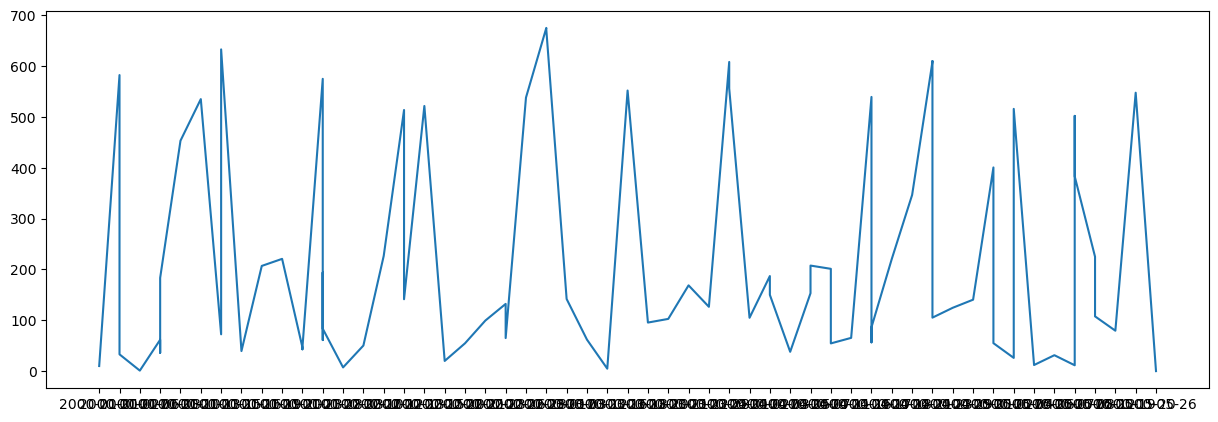

In [39]:
# What does 'quake_depth' look like?

plt.figure(figsize=(15,5), dpi=100) 

plt.plot(quake_depth)

## _- B) 'quake_mag'_

In [40]:
quake_mag.head(5)

datetime
2000-01-01    6.0
2000-01-02    5.5
2000-01-02    5.8
2000-01-05    5.6
2000-01-05    6.1
Name: mag, dtype: float64

In [41]:
# Check for missing values

quake_mag.isnull().sum()

0

In [42]:
# Check for duplicates

dups = quake_mag.duplicated()
dups.sum()

152

In [43]:
# View duplicates

dups=quake_mag[quake_mag.duplicated()]

In [44]:
dups

datetime
2000-01-05    5.5
2000-01-05    5.6
2000-01-05    5.8
2000-01-06    6.1
2000-01-07    5.5
2000-01-08    5.6
2000-01-08    6.4
2000-01-09    5.5
2000-01-13    6.2
2000-01-14    5.5
2000-01-15    5.8
2000-01-15    6.0
2000-01-16    5.9
2000-01-16    5.7
2000-01-17    5.8
2000-01-17    5.6
2000-01-18    5.5
2000-01-19    6.0
2000-01-20    5.8
2000-01-20    5.5
2000-01-20    5.8
2000-01-20    6.1
2000-01-21    5.7
2000-01-21    5.8
2000-01-22    5.5
2000-01-23    5.8
2000-01-23    5.5
2000-01-23    5.6
2000-01-23    5.5
2000-01-23    5.8
2000-01-23    5.5
2000-01-28    5.5
2000-01-28    6.0
2000-01-28    5.5
2000-01-28    5.6
2000-02-03    5.7
2000-02-03    5.5
2000-02-03    5.5
2000-02-06    5.5
2000-02-10    5.5
2000-02-10    5.6
2000-02-12    5.9
2000-02-12    5.9
2000-02-13    6.0
2000-02-13    5.7
2000-02-15    5.9
2000-02-16    5.7
2000-02-17    5.9
2000-02-18    5.6
2000-02-20    5.7
2000-02-21    5.7
2000-02-21    5.7
2000-02-22    5.5
2000-02-23    5.6
2000-02-23    5.5
2

In [45]:
quake_mag.shape

(169,)

In [46]:
quake_mag=quake_mag.drop_duplicates() # Remove duplicates

In [47]:
quake_mag.shape

(17,)

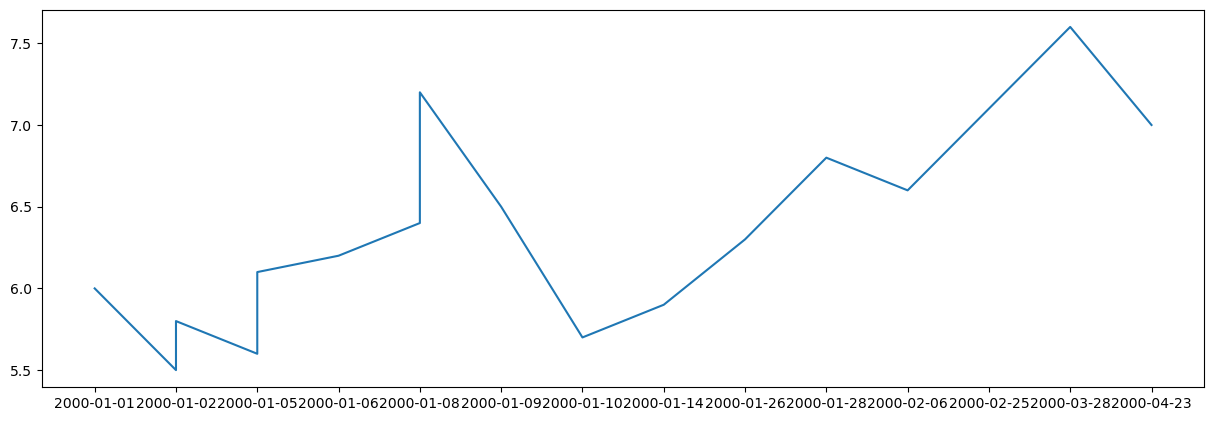

In [48]:
# What does 'quake_mag' look like?

plt.figure(figsize=(15,5), dpi=100) 

plt.plot(quake_mag)

# 2) Decomposition

I'll start by looking at 'quake_depth'

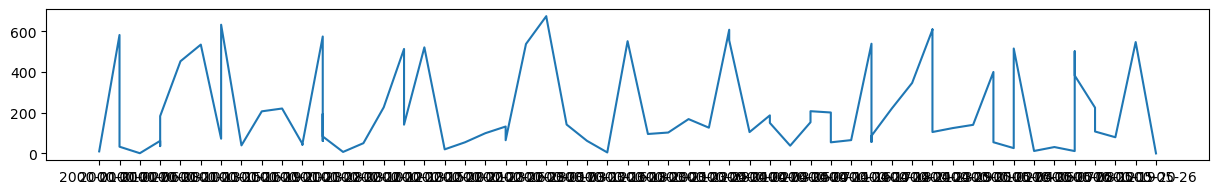

In [87]:
plt.figure(figsize=(15,2), dpi=100) 

plt.plot(quake_depth)

In [88]:
depth_decomp=sm.tsa.seasonal_decompose(quake_depth,
                                      model='additive',
                                      period=6)

In [89]:
from pylab import rcParams

rcParams['figure.figsize'] = 18, 10

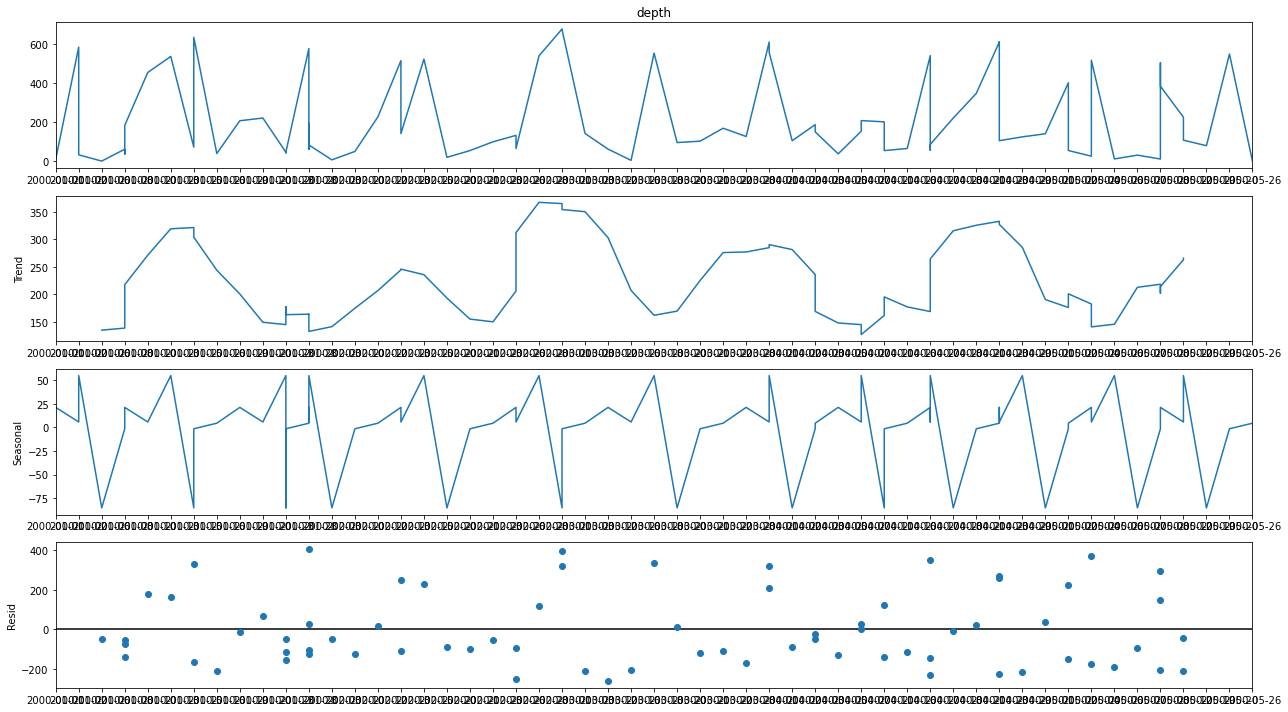

In [90]:
depth_decomp.plot()
plt.show()

# 3) Identify Components of Time Series

## _- A) Trend_

No trend, appears stationary

## _- B) Seasonality_

It appears to form a regular seasonal pattern. Low depth, intermediate depth, then low depth. The pattern repeats. Whenever there's a deep earthquake, there's a shallow one almost immediately.

## _- C) Cycle_

I would want to see more of a trend to identify a cycle.

## _- D) Noise_

Most of the entries are noisy!

# 4) Analyze Stationarity

In [94]:
from statsmodels.tsa.stattools import adfuller

def dickey_fuller(timeseries):
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

dickey_fuller(quake_depth)

Dickey-Fuller Stationarity test:
Test Statistic                -8.391630e+00
p-value                        2.358114e-13
Number of Lags Used            0.000000e+00
Number of Observations Used    7.700000e+01
Critical Value (1%)           -3.518281e+00
Critical Value (5%)           -2.899878e+00
Critical Value (10%)          -2.587223e+00
dtype: float64


__Notes__

The test statistic (-8.39) is less than the critical value (-2.89), disproving the existence of unit root. I can successfully rule out my null hypothesis and confirm that my data is stationary. 

- unit root - 'a stochastic trend in a time series, sometimes called a “random walk with drift”; If a time series has a unit root, it shows a systematic pattern that is unpredictable.' -[statistichowto.com](https://www.statisticshowto.com/unit-root/)

# 5) Autocorrelation

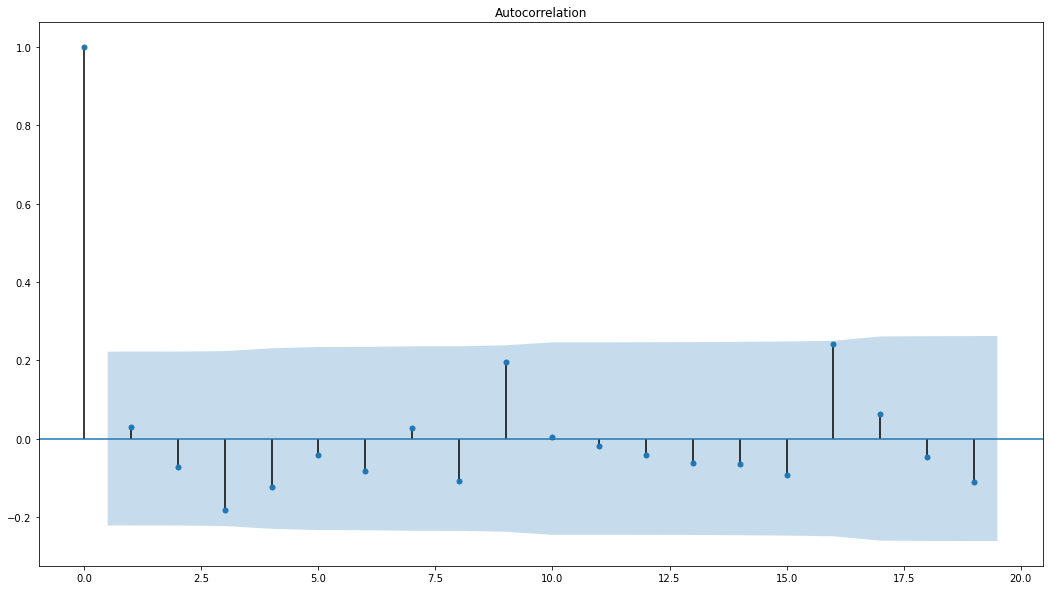

In [95]:
# Import the autocorrelation and partial correlation plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

plot_acf(quake_depth)
plt.show()

__Notes__

In the chart above, the vertical lines are confined within the shaded blue area. Double confimation that the data is stationary.